Se importan los paquetes a utilizar

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Se carga el dataset

In [15]:
data= pd.read_csv('transaction_dataset.csv')
data

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.000000,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.00,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.000000,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.00,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.050000,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.00,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.000000,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.00,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.000000,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421896,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.00,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,12.000000,2.821060,0.465461,12.200000,9.166365,0.0,0.0,0.0,17,36.665461,36.673777,0.0,0.008316,2.0,1.337000e+00,0.000000e+00,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,1.337000e+00,0.668500,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000,1.0,1.337000e+01,0.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13.37,1.337000e+01,13.370000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,218

La columna Index no aporta información relevante para la detección de fraudes ya que simplemente es una columna para ordenar las transacciones. Para el entrenamiento del programa dicha columna se puede eliminar.

In [23]:
#Se eliminan las columnas Unnamed e Index
data.drop(columns=['Index'], inplace=True)

**Análisis de las variables categóricas**

In [4]:
#Se imprimen las columnas con variables categóricas
data.describe(include='object').T

,count,unique,top,freq
Address,3468,3443,0x4cc930a91865e30feff38465ace57711e3923881,2
ERC20 most sent token type,3460,159,0,1985
ERC20_most_rec_token_type,3457,238,0,1985


In [5]:
#Se ve qué tipo de datos hay en cada una de las columnas anteriores y cuál es la frecuencia con la que se repiten
for column in data.select_dtypes(include='object').columns:
    print(data[column].value_counts())
    print('-'*20)

0x4cc930a91865e30feff38465ace57711e3923881    2
0x4cce03d1fd8aa1d6172cec74d75bd1df9e6a8ac2    2
0x4c391cc032c9107b596267610a05262c90fc2df7    2
0x4c7f6d5b287054bf41f9d49ea8d2ca6e6837850b    2
0x4c268c7b1d51b369153d6f1f28c61b15f0e17746    2
                                             ..
0x1a13f517b8299bf79c29740984836887869dee79    1
0x20ccea5b26e2b5134dc6f2b45bb3ffd2a519e99f    1
0x33ce09eec053e1a4bf847046135a94a4ec5f7260    1
0x254a716fda04213e3350bc9bcaf41c87062484be    1
0x246d33cb3c6f9ac6ba33920d572c10257cc3406d    1
Name: Address, Length: 3443, dtype: int64
--------------------
0                            1985
None                          843
OmiseGO                        67
EOS                            64
Golem                          56
                             ... 
Guaranteed Entrance Token       1
Celsius                         1
SingularityNET                  1
district0x                      1
BlockchainPoland                1
Name:  ERC20 most sent token type, 

Como se puede observar, la mayoría de datos de la columna Address son únicos, menos algunos que se repiten como mucho dos veces. Por ello se va a realizar un análisis de los datos no únicos de dicha columna para observar si es un campo relevante para la detección de fraudes. 

In [6]:
# ¿Cuantas direcicones no son únicas?
_, uniq_idx, counts = np.unique(data['Address'].to_numpy(), return_index=True, return_counts=True)
non_unique_addresses_idx = uniq_idx[counts > 1]
print("non-unique adresses count: {}".format(len(non_unique_addresses_idx), end='\n\n'))

# ¿Cuál es el flag de esas direcicones?
non_unique_addresses_flags = data.iloc[non_unique_addresses_idx]['FLAG']
print("flags of non-unique adresses: ", end='')
print(*non_unique_addresses_flags)

non-unique adresses count: 25
flags of non-unique adresses: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


Como se puede observar en la salida del código anterior, solo hay 25 datos no únicos en la columna Address. Además, todos los datos repetidos pertenecen a transacciones no fraudulentas con lo que este campo no aporta información relevante y se puede eliminar. 

Las otras dos columnas con datos categóricos sólo muestran el tipo de criptomonedas enviadas/recibidas, lo cual tampoco aporta información relevante para la detección de fraudes.

In [16]:
#Se eliminan las columnas con información irrelevante
data.drop(columns=['Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type'], inplace=True)

**Análisis de columnas numéricas**

Lo primero que se realiza es una descripción de los datos numéricos de cada columna, mostrando el número total de datos por columna, la media, la mediana, el máximo, el mínimo y los cuartiles. 

In [8]:
# De las variables numéricas hallar datos estadísticos: máximo, mínimo, media, mediana y cuartiles
stats_df = data.describe()
# Obtener y añadir la mediana
median = pd.DataFrame(data.median())
median = median.transpose()
median.rename(index = {0:'median'},inplace = True)
stats_df = stats_df.append(median).transpose() # Hay q igualarlo porq append() devuelve nuevo df
stats_df

,count,mean,std,min,25%,50%,75%,max,median
Unnamed: 0,3468.0,1.733500e+03,1.001270e+03,0.00,866.750000,1733.500000,2600.250000,3.467000e+03,1733.500000
Index,3468.0,1.282033e+03,8.931717e+02,1.00,434.000000,1199.500000,2066.250000,2.933000e+03,1199.500000
FLAG,3467.0,0.000000e+00,0.000000e+00,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
Avg min between sent tnx,3467.0,5.556958e+03,2.331401e+04,0.00,0.000000,22.790000,792.605000,4.302877e+05,22.790000
Avg min between received tnx,3467.0,9.678659e+03,2.635889e+04,0.00,0.000000,1306.920000,7134.605000,4.821755e+05,1306.920000
Time Diff between first and last (Mins),3467.0,2.588350e+05,3.472699e+05,0.00,318.100000,105904.980000,372504.910000,1.954861e+06,105904.980000
Sent tnx,3467.0,1.564275e+02,9.068199e+02,0.00,1.000000,3.000000,15.000000,1.000000e+04,3.000000
Received Tnx,3467.0,1.859414e+02,9.751143e+02,0.00,2.000000,5.000000,36.000000,1.000000e+04,5.000000
Number of Created Contracts,3467.0,5.069224e+00,1.458393e+02,0.00,0.000000,0.000000,0.000000,6.453000e+03,0.000000
Unique Received From Addresses,3467.0,3.055495e+01,3.147894e+02,0.00,1.000000,2.000000,5.000000,9.999000e+03,2.000000


Como se puede observar de la salida anterior, existen algunas columnas cuyos valores son todos nulos. Por ello, dichas columnas se pueden eliminar ya que no son relevantes para el modelo. 

In [17]:
#Se eliminan las columnas que solo tienen ceros:
data.drop(columns=[' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx',
                 ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract', ' ERC20 avg time between sent tnx'], inplace=True)

A continuación se procede a realizar la matriz de correlaciones entres los diferentes campos del dataset. Las correlaciones que son interesantes son las de la columna FLAG, ya que dicha columna es la variable de salida del modelo (indica si una transacción es normal (0) o fraudulenta (1))

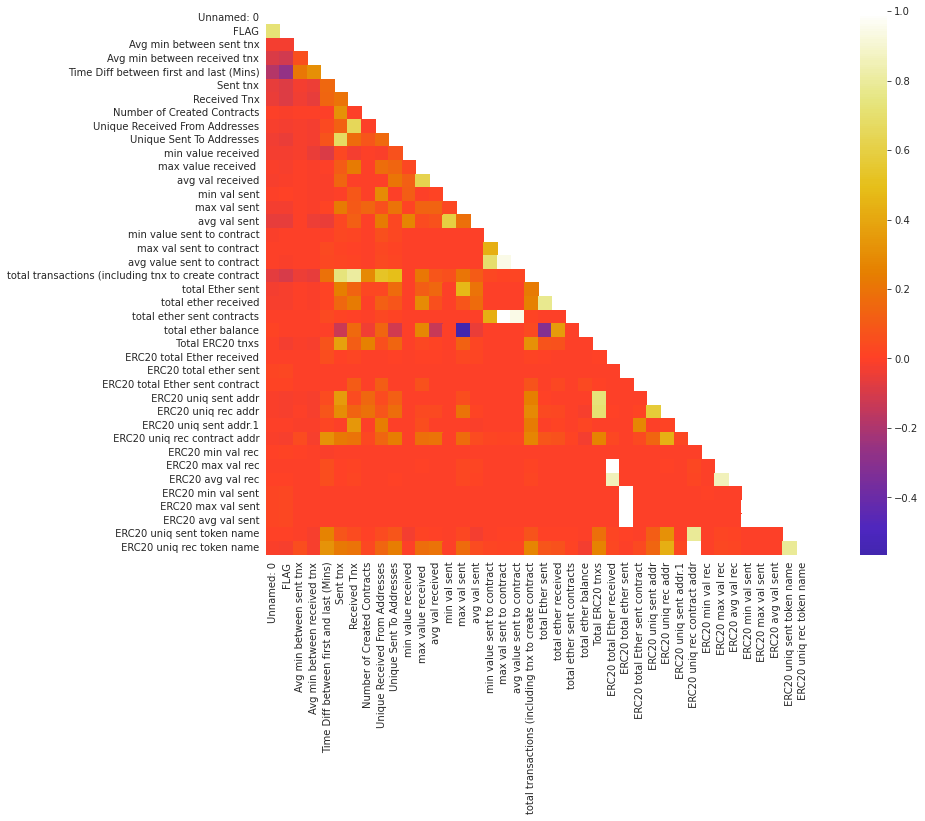

In [24]:
# Matriz de Correlación
corr = data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

In [26]:
#Encontrar las correlaciones más altas,
print('\033[1m'+'Listado de las variables con mayor influencia en el tipo de transacción junto a su coeficiente de correlación:'+'\033[0m')
important_var_list = []
for i in range(0,len(corr)):
    if corr['FLAG'][i] > 0.02:
        print('{} {}'.format(corr.index[i],corr.loc[corr.index[i],'FLAG']))
        important_var_list.append(corr.index[i])

Listado de las variables con mayor influencia en el tipo de transacción junto a su coeficiente de correlación:
Unnamed: 0 0.7191526526851808
FLAG 1.0
 ERC20 total ether sent 0.024762246540286807
 ERC20 min val sent 0.025364154087447317
 ERC20 max val sent 0.025038127044247467
 ERC20 avg val sent 0.02504351016185636


In [27]:
#Se guarda la matriz de correlación en un csv
corr.to_csv('matriz_correlacion.csv')

 **Tratamiento de Missing** 

Para saber qué datos faltan en el dataset y poder decidir cómo trabajar con ellos es necesario realizar un análisis de dichos datos. 

Lo primero que se va a realizar es una gráfica para ver de forma visual donde estan los datos de que faltan

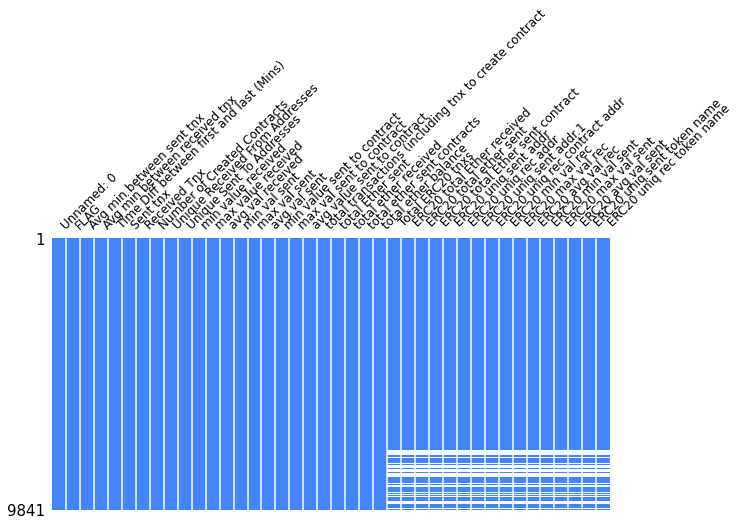

In [28]:
import missingno

missingno.matrix(data,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

Se procede a realizar una lista con los datos faltantes de cada columna

In [29]:
# Lista con los missing de cada columna
missing = data.isna().sum()
# Creamos dataframe con columnas y missing values
missing_df = pd.DataFrame([data.columns,missing]).transpose()
# Nos quedamos solo con  las columnas que tengan missing
for index in missing_df.index:
    if missing_df.iloc[index,1] > 0:
        print('Columna: {}, N of NaN: {}, Index in Dataframe: {}'.format(missing_df.iloc[index,0],missing_df.iloc[
            index,1],index))

Columna:  Total ERC20 tnxs, N of NaN: 829, Index in Dataframe: 24
Columna:  ERC20 total Ether received, N of NaN: 829, Index in Dataframe: 25
Columna:  ERC20 total ether sent, N of NaN: 829, Index in Dataframe: 26
Columna:  ERC20 total Ether sent contract, N of NaN: 829, Index in Dataframe: 27
Columna:  ERC20 uniq sent addr, N of NaN: 829, Index in Dataframe: 28
Columna:  ERC20 uniq rec addr, N of NaN: 829, Index in Dataframe: 29
Columna:  ERC20 uniq sent addr.1, N of NaN: 829, Index in Dataframe: 30
Columna:  ERC20 uniq rec contract addr, N of NaN: 829, Index in Dataframe: 31
Columna:  ERC20 min val rec, N of NaN: 829, Index in Dataframe: 32
Columna:  ERC20 max val rec, N of NaN: 829, Index in Dataframe: 33
Columna:  ERC20 avg val rec, N of NaN: 829, Index in Dataframe: 34
Columna:  ERC20 min val sent, N of NaN: 829, Index in Dataframe: 35
Columna:  ERC20 max val sent, N of NaN: 829, Index in Dataframe: 36
Columna:  ERC20 avg val sent, N of NaN: 829, Index in Dataframe: 37
Columna:  E

De los datos que faltan vemos cuántos pertenecen a transacciones fraudulentas

In [30]:
non_fraud_rows, fraud_rows = np.where( [data.iloc[:,0]==1] )
print(data.iloc[fraud_rows,:].isna().sum()[-20:])

total Ether sent                    0
total ether received                0
total ether sent contracts          0
total ether balance                 0
 Total ERC20 tnxs                   0
 ERC20 total Ether received         0
 ERC20 total ether sent             0
 ERC20 total Ether sent contract    0
 ERC20 uniq sent addr               0
 ERC20 uniq rec addr                0
 ERC20 uniq sent addr.1             0
 ERC20 uniq rec contract addr       0
 ERC20 min val rec                  0
 ERC20 max val rec                  0
 ERC20 avg val rec                  0
 ERC20 min val sent                 0
 ERC20 max val sent                 0
 ERC20 avg val sent                 0
 ERC20 uniq sent token name         0
 ERC20 uniq rec token name          0
dtype: int64


Como se puede observar, la mayoría de los datos faltantes pertenecen a transacciones fraudulentas por lo que, para no eliminarlas, rellenamos los valores con la mediana de la columna

In [31]:
#Se reemplazan los valores faltantes por la mediana
data.fillna(data.median(), inplace=True)

**Creación del modelo de detección de anomalías**

Lo primero que hacemos una exploración de las transacciones del dataset para ver qué porcentaje de ellas son fraudulentas y qué porcentaje son normales. 

In [32]:
print(data['FLAG'].value_counts())

0    7662
1    2179
Name: FLAG, dtype: int64


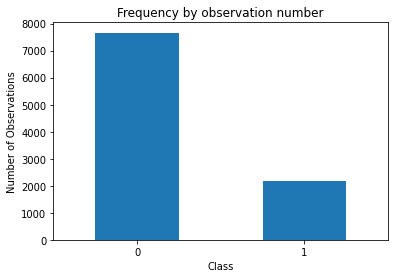

In [33]:
count_classes = pd.value_counts(data['FLAG'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

Como se puede observar es un dataset con datos desbalanceados (mayor número de transacciones normales que fraudulentas), aunque eso era de esperar ya que la clase anómala es siempre menor. 

El algoritmo a implementar va a ser Isolation Forest. Este modelo es como un árbol que va clasificando los datos en función de sus valores. Cuando se llega a la máxima profundidad en una de sus ramas, ese valor se cataloga como anómalo, ya que suelen ser los que menos características tienen en común con el resto de datos. 

Para poder entrenar el modelo se necesita separar los datos en dos conjuntos: Entrenamiento y test. 

In [34]:
cols = list(data.columns[1:len(data.columns)-1]) # Quitamos el id y la variable y dependiente 
X = data[cols].values
y=data['FLAG']

# Division of dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [35]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(7872, 38) (7872,)
(1969, 38) (1969,)


Creación y entrenamiento del modelo

In [36]:
# Creación del modelo
if_model = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 1)
# Entrenamiento del modelo
if_model.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Predicción de las variables y del conjunto de test y evaluación del modelo

In [43]:
y_pred = if_model.predict(X_test)

In [62]:
y_pred = [0 if prediction == 1 else 1 for prediction in y_pred ]

In [39]:
# Función para imprimir la matriz de confusión
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

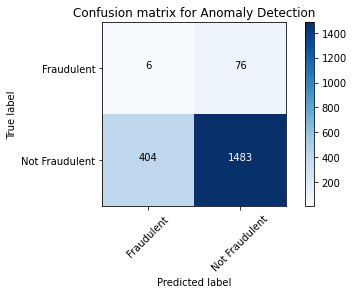

In [63]:
# Creamos e imprimimos la matriz de confusión
conf_matrix_if = confusion_matrix(y_pred, Y_test,labels = [1,0]) # Coloco este orden de labels para que los fraudulentos queden como TP y los no fraudulentos como TN (ya que lo que se quiere ver es si son fraudulentos o no) 
plot_confusion_matrix(conf_matrix_if, classes=['Fraudulent','Not Fraudulent'],normalize= False,  title='Confusion matrix for Anomaly Detection')

In [46]:
def calculate_metrics(real, predicted):
    print("Accuracy: {:.4f}".format(accuracy_score(real, predicted)))
    print("Precision: {:.4f}".format(precision_score(real, predicted,average = 'weighted')))
    # La sensibilidad es equivalente al recall
    print("Sensibilidad: {:.4f}".format(recall_score(real, predicted,average = 'weighted')))
    print("F1: {:.4f}".format(f1_score(real, predicted,average = 'weighted',labels=np.unique(predicted))))

In [64]:
calculate_metrics(Y_test, y_pred)

Accuracy: 0.7562
Precision: 0.6375
Sensibilidad: 0.7562
F1: 0.6866


**Comparativa entre diferentes hiperparámetros del Isolation Forest**

Diferente número de estimadores

In [48]:
# Creación del modelo
if_model1 = IsolationForest(n_estimators = 50, max_samples = 'auto', contamination = 'auto', max_features = 1)
# Entrenamiento del modelo
if_model1.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [49]:
# Creación del modelo
if_model2 = IsolationForest(n_estimators = 150, max_samples = 'auto', contamination = 'auto', max_features = 1)
# Entrenamiento del modelo
if_model2.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples='auto', n_estimators=150,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [50]:
# Creación del modelo
if_model3 = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = 'auto', max_features = 1)
# Entrenamiento del modelo
if_model3.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples='auto', n_estimators=200,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [52]:
y_pred1=if_model1.predict(X_test)
y_pred2=if_model2.predict(X_test)
y_pred3=if_model3.predict(X_test)

In [65]:
y_pred1 = [0 if prediction == 1 else 1 for prediction in y_pred1 ]
y_pred2 = [0 if prediction == 1 else 1 for prediction in y_pred2 ]
y_pred3 = [0 if prediction == 1 else 1 for prediction in y_pred3 ]

In [66]:
print('50 estimadores')
calculate_metrics(Y_test, y_pred1)

print('150 estimadores')
calculate_metrics(Y_test, y_pred2)

print('200 estimadores')
calculate_metrics(Y_test, y_pred3)

50 estimadores
Accuracy: 0.7603
Precision: 0.6283
Sensibilidad: 0.7603
F1: 0.6856
150 estimadores
Accuracy: 0.7466
Precision: 0.6308
Sensibilidad: 0.7466
F1: 0.6806
200 estimadores
Accuracy: 0.7593
Precision: 0.6310
Sensibilidad: 0.7593
F1: 0.6858


Diferente número de features

In [56]:
# Creación del modelo
if_model4 = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 3)
# Entrenamiento del modelo
if_model4.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=3, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [57]:
# Creación del modelo
if_model5 = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 5)
# Entrenamiento del modelo
if_model5.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=5, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [58]:
# Creación del modelo
if_model6 = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 7)
# Entrenamiento del modelo
if_model6.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=7, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [59]:
y_pred4=if_model4.predict(X_test)
y_pred5=if_model5.predict(X_test)
y_pred6=if_model6.predict(X_test)

In [67]:
y_pred4 = [0 if prediction == 1 else 1 for prediction in y_pred4 ]
y_pred5 = [0 if prediction == 1 else 1 for prediction in y_pred5 ]
y_pred6 = [0 if prediction == 1 else 1 for prediction in y_pred6 ]

In [68]:
print('3 features')
calculate_metrics(Y_test, y_pred4)

print('5 features')
calculate_metrics(Y_test, y_pred5)

print('7 features')
calculate_metrics(Y_test, y_pred6)

3 features
Accuracy: 0.7593
Precision: 0.6339
Sensibilidad: 0.7593
F1: 0.6866
5 features
Accuracy: 0.7628
Precision: 0.6293
Sensibilidad: 0.7628
F1: 0.6869
7 features
Accuracy: 0.7583
Precision: 0.6386
Sensibilidad: 0.7583
F1: 0.6877


Combinación de los dos mejores modelos

En función de la precisión el mejor modelo sería con 100 estimadores y 7 features (modelo 6) y en función del accuracy sería con 50 estimadores y 5 features.

In [69]:
# Creación del modelo
if_model7 = IsolationForest(n_estimators = 50, max_samples = 'auto', contamination = 'auto', max_features = 7)
# Entrenamiento del modelo
if_model7.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=7, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [70]:
y_pred7 = if_model7.predict(X_test)
y_pred7 = [0 if prediction == 1 else 1 for prediction in y_pred7 ]

In [71]:
calculate_metrics(Y_test, y_pred7)

Accuracy: 0.7623
Precision: 0.6412
Sensibilidad: 0.7623
F1: 0.6898


Comparandolo con las métricas del modelo 6, el modelo 7 obtiene una mejor precisión y un mejor accuracy por lo que nos quedamos con este modelo. 

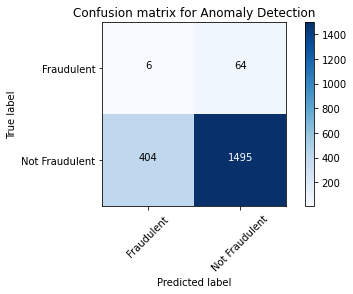

In [72]:
# Creamos e imprimimos la matriz de confusión
conf_matrix_if = confusion_matrix(y_pred7, Y_test,labels = [1,0]) # Coloco este orden de labels para que los fraudulentos queden como TP y los no fraudulentos como TN (ya que lo que se quiere ver es si son fraudulentos o no) 
plot_confusion_matrix(conf_matrix_if, classes=['Fraudulent','Not Fraudulent'],normalize= False,  title='Confusion matrix for Anomaly Detection')